# Repeated Radial Basis Function for Timeseries

Using repeated radial basis functions to approximate a function with cyclical patterns when you don't want to use timeseries based statistics.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as graph
import seaborn as sns

import statsmodels.api as sm

from tqdm import tqdm

sns.set_style('whitegrid')
graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


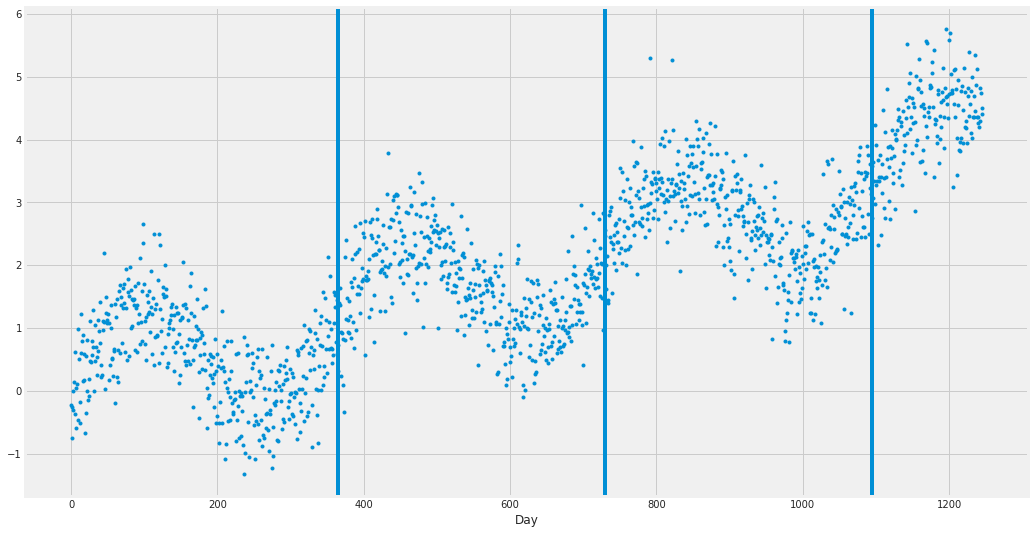

In [2]:
x = np.linspace(0, (3*365)+150, 1500)
gt = np.sin((x * 2 * np.pi) / (365)) + (0.003 * x)  # Repeat every 365 days
y = gt + stats.norm(0, 0.5).rvs(len(gt))

graph.figure(figsize=(16, 9))
graph.plot(x, y, '.')
graph.axvline(365)
graph.axvline(365*2)
graph.axvline(365*3)
graph.xlabel('Day')
graph.show()

# Can a linear model fix this?

30.416666666666668


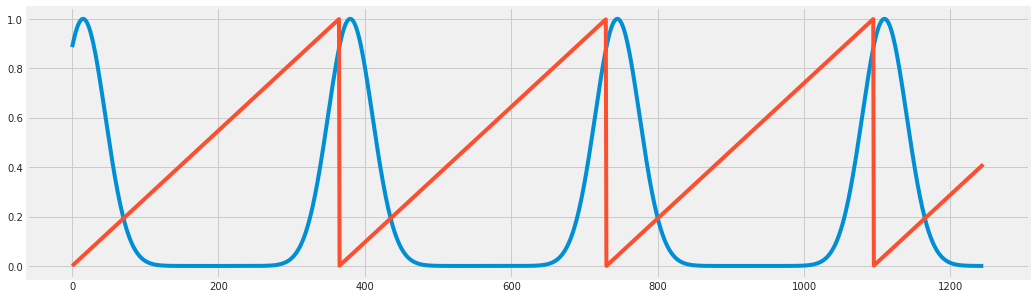

In [3]:
def rbf(xin, center, period, std=1):
    n_repeats = int(xin.max() // period)
    repeats = np.ones(n_repeats+1) * np.arange(0, 1+n_repeats) * 365
    
    center_vec = repeats - (-center)
    center_vec = np.tile(center_vec, (len(xin), 1))
    
    diff = (xin - center_vec.T).T
    
    mod = diff 
    return np.exp((-(mod) ** 2) / (2 * std ** 2)).max(axis=1)  # calling max on the row gets the strongest RBF

year_len = 365
month_len = year_len / 12
print(month_len)

rbf_out = rbf(x, 15, year_len, std=month_len)

graph.figure(figsize=(16, 5))
graph.plot(x, rbf_out)
graph.plot(x, (x % year_len) / year_len)
graph.show()

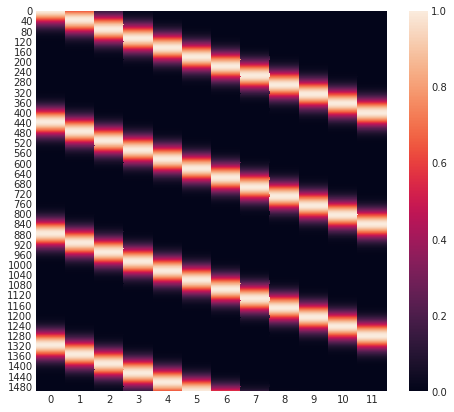

,x,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,0.000000,1.000000,0.606531,0.135335,0.011109,0.000335,0.000004,1.522998e-08,2.289735e-11,1.266417e-14,2.576757e-18,1.928750e-22,5.311092e-27
1,0.830554,0.999627,0.623088,0.142878,0.012053,0.000374,0.000004,1.793454e-08,2.770989e-11,1.575016e-14,3.293371e-18,2.533389e-22,7.169166e-27
2,1.661107,0.998510,0.639621,0.150730,0.013067,0.000417,0.000005,2.110363e-08,3.350894e-11,1.957355e-14,4.206144e-18,3.325095e-22,9.670070e-27
3,2.491661,0.996650,0.656103,0.158894,0.014156,0.000464,0.000006,2.481421e-08,4.049139e-11,2.430695e-14,5.367891e-18,4.360964e-22,1.303367e-26
4,3.322215,0.994053,0.672508,0.167375,0.015325,0.000516,0.000006,2.915545e-08,4.889234e-11,3.016250e-14,6.845410e-18,5.715274e-22,1.755416e-26


In [4]:
# Now lets create some features
data = pd.DataFrame(x, columns=['x'])
for month_i in range(12):
    data[f'month_{month_i}'] = rbf(data['x'].values, month_i * month_len, period=year_len, std=month_len)

# Check out results!
graph.figure(figsize=(7, 7))
sns.heatmap(data[data.columns[1:]].values)
graph.show()

display(data.head())

In [5]:
from sklearn.linear_model import LinearRegression

split_pos = int(len(data.values) * 0.33)
x_train, x_test = data.values[:split_pos, :], data.values[split_pos:, :]
y_train, y_test = y[:split_pos], y[split_pos:]

lm = LinearRegression().fit(x_train, y_train)
print('R2', lm.score(x_train, y_train))

print(lm.coef_)

R2 0.5749920239087785
[ 0.00315862 -0.46690209  1.10958038 -0.21756312  1.24479356  0.25192524
  0.22586716  0.72017416 -1.00940417  0.47746673 -0.75315222 -0.19740564
  0.15114054]


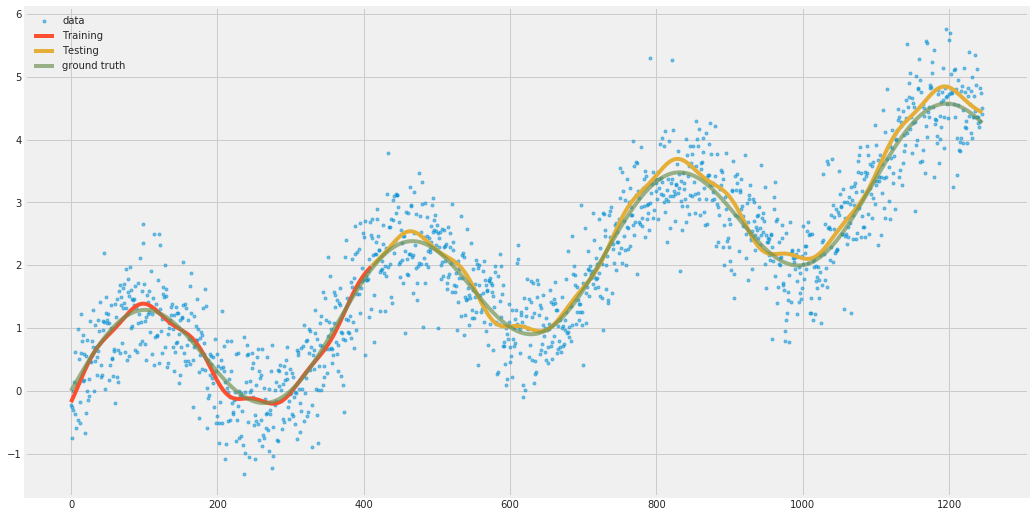

In [6]:
graph.figure(figsize=(16, 9))
graph.plot(x, y, '.', alpha=0.5, label='data')
graph.plot(x_train[:, 0], lm.predict(x_train), label='Training')
graph.plot(x_test[:, 0], lm.predict(x_test), linewidth=4, label='Testing')
graph.plot(x, gt, alpha=0.66, label='ground truth')
graph.legend()
graph.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     50.06
Date:                Mon, 28 May 2018   Prob (F-statistic):           9.64e-81
Time:                        20:42:55   Log-Likelihood:                -379.49
No. Observations:                 495   AIC:                             787.0
Df Residuals:                     481   BIC:                             845.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3716      2.117     -0.175      0.861      -4.532       3.789
x1             0.0032      0.000      7.076      0.000       0.002       0.004
x2            -0.4669      1.847     -0.253      0.801      -4.096       3.162
x3             1.1096      0.701      1.584      0.114      -0.267       2.486
x4            -0.2176      1.768     -0.123      0.902      -3.691       3.256
x5             1.2448      0.874      1.424      0.155      -0.472       2.962
x6             0.2519      1.721      0.146      0.884      -3.130       3.634
x7             0.2259      0.936      0.241      0.809      -1.613       2.065
x8             0.7202      1.721      0.418      0.676      -2.662       4.103
x9            -1.0094      0.888     -1.136      0.256      -2.755       0.736
x10            0.4775      1.772      0.269      0.788      -3.004       3.959
x11           -0.7532      0.724     -1.041      0.298      -2.175       0.669
x12           -0.1974      1.844     -0.107      0.915      -3.820       3.425
x13            0.1511      0.529      0.286      0.775      -0.887       1.190
==============================================================================
Omnibus:                        1.692   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.556
Skew:                          -0.027   Prob(JB):                        0.459
Kurtosis:                       2.731   Cond. No.                     4.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

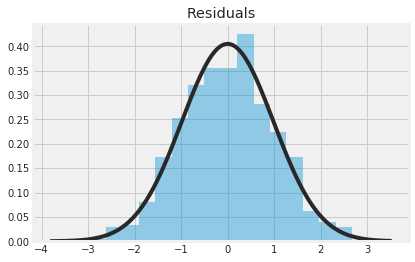

In [7]:
results = sm.OLS(y_train, sm.add_constant(x_train)).fit()

display(results.summary())

graph.title('Residuals')
sns.distplot(results.resid_pearson, fit=stats.norm, kde=False)
graph.show()

## Modeling with uncertainty with Bayesian Statistics

Since this matters quite a lot more since the more RBFs you use the less certain you are about their coefs 

In [8]:
with pm.Model() as uncertainty:
    # y ~ X @ M + b
    # Priors
    m = pm.Normal('m', mu=0, sd=1000, shape=(x_train.shape[1]))
    b = pm.Normal('b', mu=0, sd=1000)
    sigma = pm.HalfNormal('sigma', sd=1000)
    
    # Likelihood
    obs = pm.Normal('obs', mu=pm.math.dot(x_train, m) + b, sd=sigma, observed=y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, b, m]
 11%|█         | 280/2500 [00:07<01:02, 35.50it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '29831' (I am process '29832')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/stephen/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '29831' (I am process '29833')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/stephen/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
 23%|██▎       | 563/2500 [00:17<00:59, 32.34it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '29832' (I am process '29833')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/stephen/.theano/compiledir_Lin

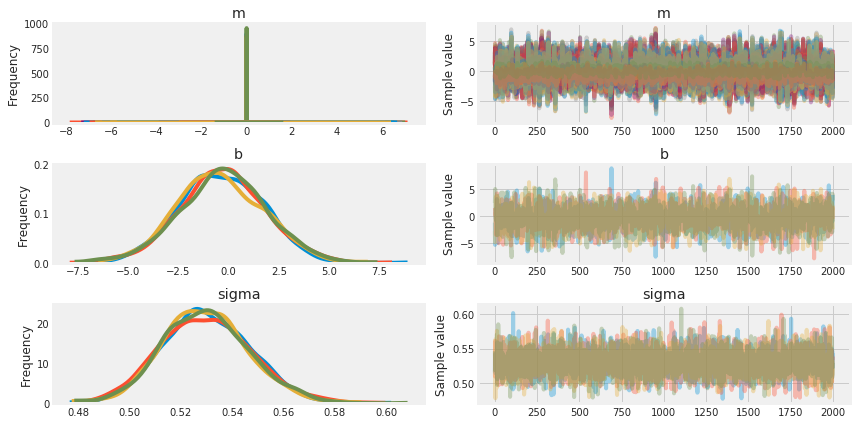

CPU times: user 2.92 s, sys: 1.26 s, total: 4.18 s
Wall time: 1min 47s


In [9]:
%%time
with uncertainty:
    # Sample Posterior
    trace = pm.sample(2000)
    
    pm.traceplot(trace)
    graph.show()

 96%|█████████▌| 958/1000 [00:02<00:00, 473.81it/s]


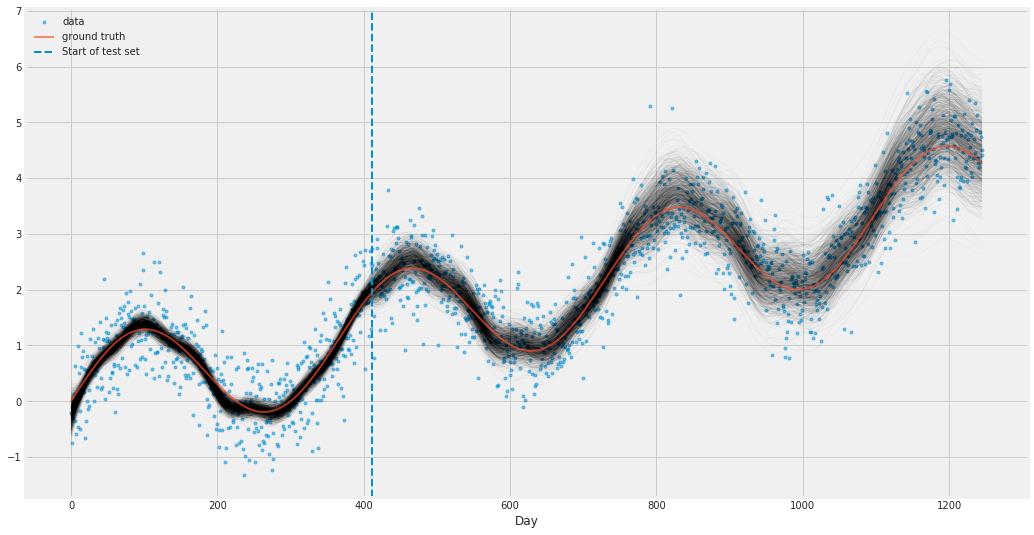

In [10]:
n_draws = 1000   

graph.figure(figsize=(16, 9))
graph.plot(x, y, '.', alpha=0.5, label='data')

# Plot posterior model
for i, posterior_sample in tqdm(enumerate(reversed(trace)), total=n_draws):
    if i > n_draws:
        break

    mi = posterior_sample['m']
    bi = posterior_sample['b']

    graph.plot(x, data.values @ mi + bi, linewidth=0.5, color='black', alpha=0.05)

graph.plot(x, gt, alpha=0.66, linewidth=2, label='ground truth')
graph.axvline(x[len(y_train)], linestyle='--', linewidth=2, label='Start of test set')
graph.xlabel('Day')
graph.legend()
graph.show()

As you can you see and what makes Bayesian statistics soo nice is that we are seeing the slowly getting more uncertainty as we go more distant into the unseen future. 

_Stephen Anthony Rose_